In [14]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from sympy import cos, sin, exp, Matrix, sqrt
from sympy.simplify.fu import TR10, TR9
import pandas as pd

from IPython.display import display, Math
from IPython.display import display as disp
from utils import symdisp, symplot
import ipywidgets as widgets
from ipywidgets import interact

from optic.comm.modulation import modulateGray, demodulateGray, grayMapping
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, upsample
from optic.comm.metrics import signalPower
from optic.plot import eyediagram
from optic.utils import parameters

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.options.display.float_format = '{:,d}'.format

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
figsize(10, 4)

# Transmissão Digital da Informação

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Canal-AWGN" data-toc-modified-id="Canal-AWGN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Canal AWGN</a></span><ul class="toc-item"><li><span><a href="#Variável-aleatória-com-distribuição-gaussiana" data-toc-modified-id="Variável-aleatória-com-distribuição-gaussiana-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Variável aleatória com distribuição gaussiana</a></span></li><li><span><a href="#Processo-estocástico-gaussiano-estacionário" data-toc-modified-id="Processo-estocástico-gaussiano-estacionário-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Processo estocástico gaussiano estacionário</a></span></li><li><span><a href="#Propriedades-importantes:" data-toc-modified-id="Propriedades-importantes:-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Propriedades importantes:</a></span></li></ul></li><li><span><a href="#Ruído-aditivo-gaussiano-branco" data-toc-modified-id="Ruído-aditivo-gaussiano-branco-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Ruído aditivo gaussiano branco</a></span><ul class="toc-item"><li><span><a href="#Filtrando-o-ruído-gaussiano-branco" data-toc-modified-id="Filtrando-o-ruído-gaussiano-branco-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Filtrando o ruído gaussiano branco</a></span></li><li><span><a href="#Exemplo:-ruído-térmico" data-toc-modified-id="Exemplo:-ruído-térmico-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Exemplo: ruído térmico</a></span></li><li><span><a href="#Gerando-numericamente-realizações-de-um-processo-gaussiano" data-toc-modified-id="Gerando-numericamente-realizações-de-um-processo-gaussiano-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Gerando numericamente realizações de um processo gaussiano</a></span></li><li><span><a href="#Efeito-do-ruído-em-sistemas-de-comunicação-digital" data-toc-modified-id="Efeito-do-ruído-em-sistemas-de-comunicação-digital-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Efeito do ruído em sistemas de comunicação digital</a></span></li></ul></li><li><span><a href="#Relação-sinal-ruído" data-toc-modified-id="Relação-sinal-ruído-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Relação sinal-ruído</a></span></li><li><span><a href="#Referências" data-toc-modified-id="Referências-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Referências</a></span></li></ul></div>

# Sistemas de Transmissão Digital da Informação


<img src="./figuras/Fig1.png" width="900">
 

## Canal AWGN

Quando transmitidos pelo canal de comunicações, o sinais enviados pelo transmissor estão sujeitos a diversos tipos de distorção. Efeitos de filtragem, interferência, distorção não-linear e diversos tipos de ruído podem estar presentes no canal de comunicações, afetando a qualidade dos sinais que chegam ao receptor. 

O modelo de canal mais importante para a análise de sistemas de comunicações digitais é o que assume que sinais transmitidos serão afetados pela presença de ruído branco gaussiano aditivo (*additive white Gaussian noise* - AWGN). Nesse modelo, o ruído é representado por um processo aleatório gaussiano, ou seja, para cada instante $t$ no tempo, o ruído $n(t)$ adicionado ao sinal é dado por uma variável aleatória gaussiana de média $\mu$ igual a zero e com uma certa variância $\sigma^2$. Desse modo, seja $s(t)$ o sinal enviado pelo transmissor ao canal, o modelo de canal AWGN assume que um ruído $n(t)$ será adicionado ao sinal de informação durante o processo de comunicação, como indicado na figura a seguir

<img src="./figuras/Fig3.png" width="700">

em que $r(t)$ representa o sinal ruidoso na entrada do receptor.

Uma das principais fontes de ruído em sistemas de comunicações é o ruído térmico. O ruído Johnson-Nyquist (ruído térmico, ruído de Johnson ou ruído de Nyquist) é o ruído eletrônico gerado pela agitação térmica dos portadores de carga (geralmente os elétrons) dentro de um condutor elétrico, que ocorre independentemente de haver ou não tensão aplicada sobre o elemento. O ruído térmico está presente em todos os circuitos elétricos e eletrônicos. A presença de ruído em circuitos eletônicos reduz a sensibilidade de receptores na detecção de sinais de potência reduzida. Alguns equipamentos eletrônicos que requerem alta sensibilidade, como receptores de telescópios de rádio, precisam ser resfriados à temperaturas criogênicas para reduzir o ruído térmico em seus circuitos.

### Variável aleatória com distribuição gaussiana

Seja $X$ uma v.a. contínua com distribuição normal (gaussiana) de média $\mu$ e variância $\sigma^2$, i.e. $X \sim \mathcal{N}\mathrm{(\mu, \sigma^2)}$, a função densidade de probablidade de $X$ será dada por

$$
p_X\left(x\right)=\frac{1}{\sqrt{2 \pi \sigma^{2}}} e^{-\frac{(x-\mu)^{2}}{2 \sigma^{2}}}
$$

para $-\infty <x < \infty$.


Exemplos:

In [6]:
μ, σ, x = sp.symbols('μ, σ, x', real=True)

π = sp.pi

p = 1 / ( sp.sqrt(2*π) * σ ) * sp.exp( -(x - μ) ** 2 / ( 2*σ**2 ) )

intervalo = np.arange(-5, 5, 0.01)
fig = None
for sigma2 in np.arange(0.5, 2.5, 0.5):
    fig = symplot(x, p.subs({μ:0, σ:np.sqrt(sigma2)}), intervalo, 
                  funLabel='$p_X(x)$ $σ^2$ = '+str(sigma2), xlabel= 'x', fig=fig);


plt.grid()
plt.ylabel('$p_X(x)$');

TypeError: symplot() got an unexpected keyword argument 'fig'

Seja $P(x_1 < X < x_2)$ a probabilidade de X assumir valores no intervalo $[x_1, x_2]$, temos que

In [7]:
μ, σ, x, x1, x2 = sp.symbols('μ, σ, x, x_1, x_2', real=True)

p = 1 / ( sp.sqrt(2*π) * σ ) * sp.exp( -(x - μ) ** 2 / ( 2*σ**2 ) )

sigma = 0.5

symdisp('P(x_1 < X < x_2) = \int_{x_1}^{x_2} p_X(x) dx =', sp.integrate(p, (x, x1, x2) ).simplify())

<IPython.core.display.Math object>

em que $\operatorname{erf}(x) =\frac{2}{\sqrt{\pi}} \int_0^x e^{-u^2} \mathrm{~d} u$.

In [8]:
for ind in range(1, 5):
    symdisp('P(-'+str(ind)+'σ<X<'+str(ind)+'σ) = \int_{-'+str(ind)+'σ}^{'+str(ind)+'σ} p_X(x) dx = ', 
            sp.N(sp.integrate(p.subs({μ:0, σ:sigma}), (x, -ind*sigma, ind*sigma)),3))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Processo estocástico gaussiano estacionário

Um processo estocástico gaussiano estacionário $X(t)$ é um processo aleatório no qual a distribuição de probabilidade conjunta de qualquer conjunto finito de variáveis aleatórias $\mathbf{X} = \left[X(t_1), X(t_2), \dots X(t_n) \right]^T$ possuirá uma distribuição conjunta gaussiana, ou seja, uma função densidade de probabilidade (fdp) dada por

$$\begin{equation} p_{\mathbf{X}}(\mathbf{x}) = \frac{1}{\sqrt{(2\pi)^n|\Sigma|}} e^{-\frac{1}{2} (\mathbf{x}-\mathbf{\mu})^T \Sigma^{-1} (\mathbf{x}-\mu)} \end{equation}\label{eq1}$$

onde $\mathbf{x}$ é um vetor coluna de dimensão $n$, $\mathbf{\mu}$ é um vetor coluna de médias de dimensão $n$, $\Sigma$ é uma matriz de covariância $n \times n$, $|\Sigma|$ é o determinante de $\Sigma$ e $^T$ representa a transposição. No caso de processos gaussianos, se as variáveis aleatórias forem mutuamente independentes, $\Sigma = \mathrm{diag}(\sigma_1^2, \sigma_2^2, \dots, \sigma_n^2)$ será uma matriz diagonal e temos que ($\ref{eq1}$) pode ser simplificada para

$$ \begin{eqnarray} p_{\mathbf{X}}(\mathbf{x}) &=& p(x_1)p(x_2)\dots p(x_n) \\ &=&\prod_{k=1}^n \frac{1}{\sqrt{2\pi \sigma_k^2}} e^{-\frac{1}{2} \frac{(x_k-\mu_k)^2}{\sigma_k^2}} \end{eqnarray}\label{eq2}$$

A propriedade de estacionariedade em um processo estocástico implica que suas estatísticas não variam ao longo do tempo. Em outras palavras, as médias e variâncias das variáveis aleatórias do processo são constantes temporalmente e as funções de autocorrelação e covariância dependem apenas da diferença entre os instantes de tempo, não do tempo em si. Essa propriedade é de grande importância na análise de processos estocásticos, pois permite simplificar a modelagem e a análise de sistemas complexos. Ao assumir que o processo é estacionário, podemos reduzir a dimensão do problema e concentrar nossos esforços na caracterização da estatística do processo em vez de sua dinâmica temporal.



### Propriedades importantes:

1. Para processos gaussianos, o conhecimento da média e da autocorrelação, i.e., $\mu_X(t)$ e $R_X(t_1, t_2)$ provê uma descrição estatística completa do processo.

2. Se um processo gaussiano $X(t)$ passa por um sistema linear e invariante no tempo (LIT), então a saída $Y(t)$ do sistema também é um processo gaussiano.

3. Para processos gaussianos, estacionariedade no sentido amplo (WSS) implica em estacionariedade estrita.

4. Uma condição suficiente para a ergodicidade de um processo estacionário de média nula $X(t)$ é que

$$\int_{-\infty}^{\infty}\left|R_X(\tau)\right| d \tau<\infty$$.

## Ruído aditivo gaussiano branco

O ruído gaussiano branco $N(t)$ é um processo estocástico estacionário em que qualquer conjunto as amostras das realizações do processo são independentes e identicamente distribuídas (i.i.d.) com uma distribuição gaussiana de média zero e variância constante. O termo "branco" refere-se ao fato de que a densidade espectral de potência do processo constante ao longo de todo o espectro de frequências, fazendo alusão à luz branca, que é composta pela combinação de todas as componentes de frequência (cores) do espectro visível.

<img src="./figuras/Fig4.png" width="900">

### Filtrando o ruído gaussiano branco

<IPython.core.display.Math object>

<IPython.core.display.Math object>

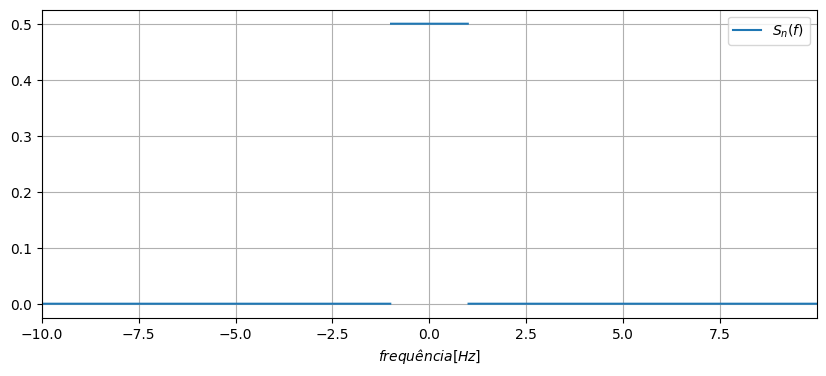

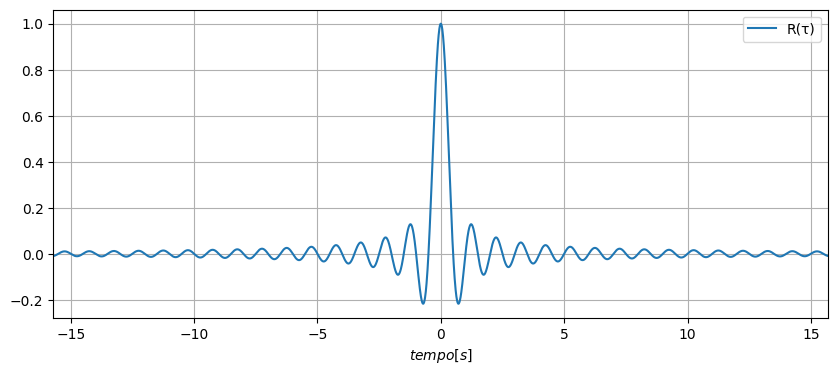

In [9]:
from sympy import fourier_transform as FT
from sympy import inverse_fourier_transform as iFT
from sympy import oo as infty

def rect(t, a):
    return (sp.Heaviside(t + a) - sp.Heaviside(t - a))

τ, f = sp.symbols('τ, f', real=True)
N0, σ , B = sp.symbols('N_0, σ, B', real=True, positive=True)

# Ruído filtrado numa banda -B < f < B:
Sn = N0/2*rect(f, B)

Rtau = iFT(Sn, f, τ)

symdisp('S_N = ', Sn)
symdisp('R(τ) = ', Rtau)

intervalo_f = np.arange(-10, 10, 0.01)
intervalo_τ = np.arange(-5*np.pi, 5*np.pi, 0.01)

symplot(f, Sn.subs({N0:1, B:1}), intervalo_f, funLabel='$S_n(f)$', xlabel= 'frequência [Hz]');
symplot(τ, Rtau.subs({N0:1,B:1}), intervalo_τ, funLabel='R(τ)');

### Exemplo: ruído térmico

A densidade de potência do ruído térmico é dada por

$$ S_n(f)=\frac{\hbar f}{2\left(e^{\frac{\hbar f}{k T}}-1\right)} $$


em que $f$ é a frequência em $Hz$, $\hbar=6.6 \times 10^{-34} \mathrm{~J}\mathrm{s}$ é a constante de Planck, $k=1.38 \times 10^{-23}  \mathrm{~J}\mathrm{K}$ é a constante de Boltzmann e $T$ é a temperatura em Kelvin.

Observações:

* O espectro acima assume valor máximo $\frac{kT}{2}$ em $f=0$ Hz;
* $\lim_{f\to \pm \infty} S_n(f) = 0$, porém a taxa de convergência é muito lenta.  Ex.: a 300 K, $S_n(f)=0.9S_n(0)$ para $f=2\times 10^{12} Hz$  

Logo, para efeitos práticos:

$$ S_n(f)=\frac{kT}{2} $$

Considerando um intervalo de frequências $[-B/2, B/2]$, a potência de ruído térmico presente nessa banda será dada por

$$
\begin{aligned}
& P_n=\int_{-B/2}^{B/2} \frac{k T}{2} d f \\
& P_n=\frac{k T}{2} \cdot 2 \frac{B}{2} =k T B/2
\end{aligned}
$$

### Gerando numericamente realizações de um processo gaussiano

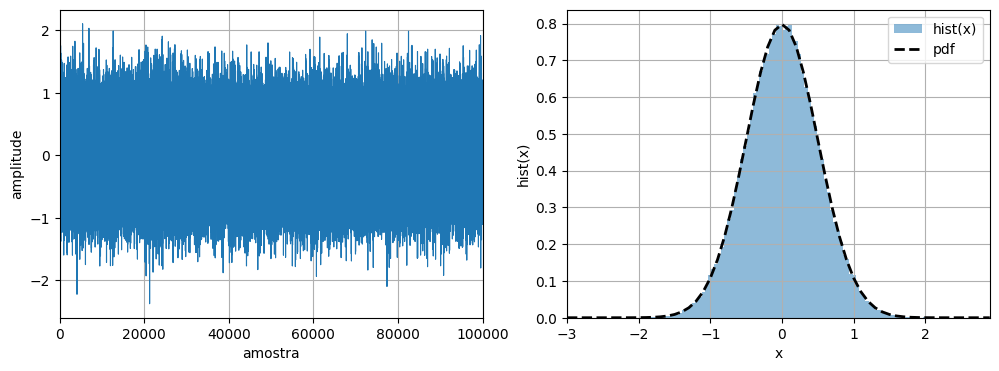

In [22]:
from numpy.random import normal

# ruído gaussiano branco
Namostras = 100000 
σ2  = 0.25  # variância
μ   = 0    # média

σ      = sqrt(σ2) 
ruido  = normal(μ, σ, Namostras)  

x = np.arange(-3, 3, 0.1)
π = np.pi

pdf = 1/np.sqrt(2*π*σ2)*np.exp(-(x-μ)**2/(2*σ2))

# plota valores e histograma
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,4))
ax1.plot(ruido,linewidth = 0.8);
ax1.grid()
ax1.set_xlabel('amostra')
ax1.set_ylabel('amplitude')
ax1.set_xlim(0,Namostras);

ax2.hist(ruido, density=True, bins=100, label = 'hist(x)',alpha=0.5);
ax2.plot(x, pdf, 'k--', label = 'pdf', linewidth=2);
ax2.grid()
ax2.legend()
ax2.set_xlabel('x')
ax2.set_ylabel('hist(x)');
ax2.set_xlim(min(x), max(x));

Veja que o sinal ilustrado acima é a realização de um processo estocástico gaussiano estacionário. Cada amostra corresponde a uma realização de uma variável aleatória (v.a) gaussiana de média nula ($\mu=0$) e variância $\sigma^2$. As variáveis aleatórias, por sua vez, são independentes e idênticamente distribuídas (i.i.ds). Vamos calcular a potência do sinal acima, considerando que para um processo ergódico na correlação, podemos assumir:

$$P_x=E\left[X^2\right] = \mu^2 + \sigma^2\approx \frac{1}{N}\sum_{k=1}^{N} x^2[k]$$

Note que esta última expressão é a mesma expressão para cálculo da potência média de um sinal determinístico. Logo, temos que:

In [23]:
# função para calcular a potência de um sinal
def pot(x):
    return x.var() + x.mean()**2

print('Potência do ruído = %.2f unidades de potência' %pot(ruido)) # veja a definição da função potSinal() acima

Potência do ruído = 0.25 unidades de potência


### Efeito do ruído em sistemas de comunicação digital

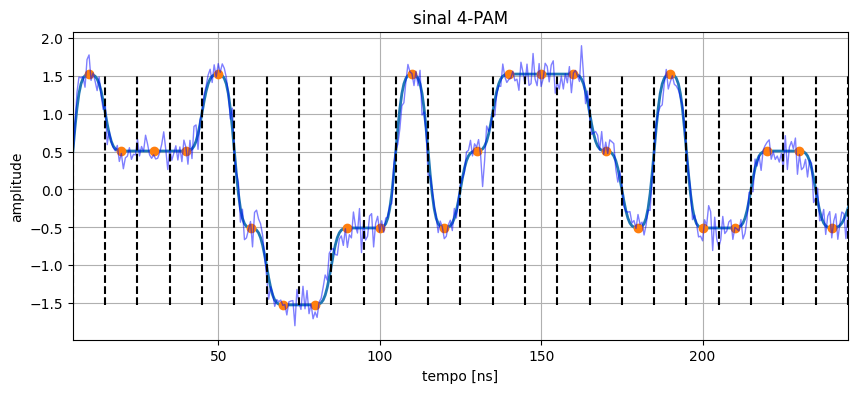

In [32]:
np.random.seed(0)

M = 4

# parâmetros da simulação
SpS = 16            # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(25*np.log2(M)))

# generate pam modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')    
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)*SpS

# pulso NRZ típico
paramPS = parameters()
paramPS.pulseType = 'nrz'
paramPS.SpS = SpS
pulse = pulseShape(paramPS)

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = sigTx.real

t = np.arange(0, sigTx.size)*(1/Fa)/1e-9

# instantes centrais dos intervalos de sinalização
symbolsUp = upsample(symbTx, SpS)
symbolsUp[symbolsUp==0] = np.nan

plt.figure(2)
plt.plot(t, sigTx,'-',linewidth=2)
plt.plot(t, symbolsUp.real,'o')
plt.xlabel('tempo [ns]')
plt.ylabel('amplitude')
plt.title('sinal '+str(M)+'-PAM')
plt.grid()

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.020  # variância
μ   = 0      # média

σ      = sqrt(σ2) 
ruido  = normal(μ, σ, Namostras)

plt.figure(2)
plt.plot(t, sigTx + ruido,'b-',alpha=0.5, linewidth=1)

t = (0.5*Ts + np.arange(0, symbTx.size*Ts, Ts))/1e-9
plt.vlines(t, min(symbTx), max(symbTx), linestyles='dashed', color = 'k');
plt.xlim(min(t), max(t));

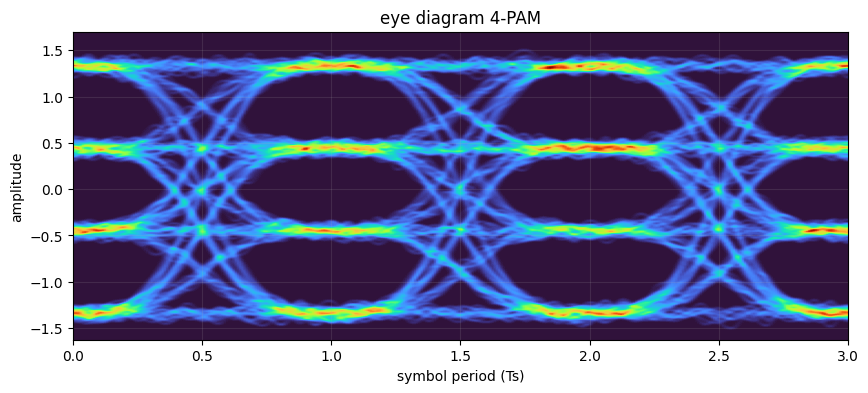

<IPython.core.display.Math object>

In [43]:
np.random.seed(0)

M = 4

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(250000*np.log2(M)))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')    
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)*SpS

# pulso 
paramPS = parameters()
paramPS.pulseType = 'nrz'
paramPS.SpS = SpS
pulse = pulseShape(paramPS)

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = sigTx.real

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.002  # variância
μ   = 0      # média

σ      = sqrt(σ2) 
ruido  = normal(μ, σ, Namostras)

# diagrama de olho
Nsamples = sigTx.size
eyediagram(sigTx+ruido, Nsamples, SpS, plotlabel= str(M)+'-PAM', ptype='fancy')

SNR = 10*np.log10(pot(sigTx)/pot(ruido))

symdisp('\mathrm{SNR} = ', round(SNR,2), 'dB')

## Relação sinal-ruído


A relação sinal-ruído (ou razão sinal-ruído, *signal-to-noise ratio* - $\mathrm{SNR}$) é uma das grandezas mais importantes na engenharia de sistemas de comunicações. A $\mathrm{SNR}$ é um indicador da presença de ruído no sistema, ou seja, a presença de distorções aleatórias e indesejáveis que afetam os sinais que carregam informação, dificultando ou impossibilitando o processo de comunicação. 

A $\mathrm{SNR}$ é definida como sendo a razão entre a potência de sinal $P_s$ e a potência do ruído $P_n$ observadas num dado sistema:

$$\mathrm{SNR} = \frac{P_s}{P_n}$$

em que $P_s = E\left[|s(t)|^2\right]$ e $P_n=E\left[|n(t)|^2\right]$, com $E[.]$ denotando valor esperado.

Quando expressa em decibéis (dB), a $\mathrm{SNR}$ é dada por

$$ \mathrm{SNR}_{dB} = 10\log_{10}P_s-10\log_{10}P_n.$$

Quanto maior a $\mathrm{SNR}$ maior a diferença entre a potência do sinal de interesse e a potência do ruído adicionado á mesma. Dessa forma, quanto maior a $\mathrm{SNR}$ melhor a qualidade do sinal.

## Referências

[1] J. G. Proakis, M. Salehi, Digital Communications, 4th Edition, McGraw Hill, 2001.